# How To Fine-Tune Decoder-Only Models?

[![Twitter Handle](https://img.shields.io/badge/Twitter-@gaohongnan-blue?style=social&logo=twitter)](https://twitter.com/gaohongnan)
[![LinkedIn Profile](https://img.shields.io/badge/@gaohongnan-blue?style=social&logo=linkedin)](https://linkedin.com/in/gao-hongnan)
[![GitHub Profile](https://img.shields.io/badge/GitHub-gao--hongnan-lightgrey?style=social&logo=github)](https://github.com/gao-hongnan)
![Tag](https://img.shields.io/badge/Tag-Brain_Dump-red)
![Tag](https://img.shields.io/badge/Level-Beginner-green)
[![Code](https://img.shields.io/badge/View-Code-blue?style=flat-square&logo=github)](https://github.com/gao-hongnan/omniverse/tree/main/omnivault/transformer)

```{contents}
:local:
```

Firstly, if you have not read my
[Generative Pre-trained Transformers (GPT) series](https://www.gaohongnan.com/influential/generative_pretrained_transformer/03_concept.html),
please have a read first to establish some basic understand on what a
decoder-only model entails.

## Dependencies

In [1]:
from __future__ import annotations

from functools import partial
from typing import List, Tuple

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from omnivault.transformer.config.composer import Composer
from omnivault.transformer.config.criterion import CRITERION_REGISTRY
from omnivault.transformer.config.decoder import (
    AddNormConfig,
    DecoderBlockConfig,
    DecoderConfig,
    MultiHeadedAttentionConfig,
    PositionwiseFeedForwardConfig,
)
from omnivault.transformer.config.generator import GeneratorConfig
from omnivault.transformer.config.optim import OPTIMIZER_REGISTRY
from omnivault.transformer.config.scheduler import SCHEDULER_REGISTRY
from omnivault.transformer.config.trainer import TrainerConfig
from omnivault.transformer.core.state import State
from omnivault.transformer.core.trainer import Trainer, TrainerEvent
from omnivault.transformer.decoder.core import GPTDecoder, GPTDecoderBlock
from omnivault.transformer.modules.attention.core import ScaledDotProductAttention
from omnivault.utils.reproducibility.seed import seed_all

## Reproducibility

In [2]:
seed_all(seed=2024, seed_torch=True, set_torch_deterministic=False)

2024

## Constructing A Reversal Dataset

In [16]:
class ReverseDataset(Dataset):

    def __init__(self, num_classes: int, seq_len: int, num_samples: int) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.seq_len = seq_len
        self.num_samples = num_samples

        self.data = torch.randint(self.num_classes, size=(self.num_samples, self.seq_len))

    def __len__(self) -> int:
        return self.num_samples

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        inp_data = self.data[idx]
        labels = torch.flip(inp_data, dims=(0,))
        return inp_data, labels

## From Causal Mask To Non-Causal Mask

We can see from our line 13 below that we mask the attention scores with
$-\infty$ whenever the `mask` tensor has a value of $0$.

```{code-block} md
---
linenos: true
emphasize-lines: 13
---

class ScaledDotProductAttention(Attention):
    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor,
        mask: torch.BoolTensor | None = None,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        # fmt: off
        d_q               = query.size(dim=-1)

        attention_scores  = torch.matmul(query, key.transpose(dim0=-2, dim1=-1)) / torch.sqrt(torch.tensor(d_q).float())        # [B, H, T, d_q] @ [B, H, d_q, T] = [B, H, T, T]
        attention_scores  = attention_scores.masked_fill(mask == 0, float("-inf")) if mask is not None else attention_scores    # [B, H, T, T]

        attention_weights = attention_scores.softmax(dim=-1)        # [B, H, T, T]
        attention_weights = self.dropout(attention_weights)         # [B, H, T, T]

        context_vector    = torch.matmul(attention_weights, value)  # [B, H, T, T] @ [B, H, T, d_v] = [B, H, T, d_v]
        # fmt: on
        return context_vector, attention_weights
```

And the mask we pass into the `ScaledDotProductAttention` class is constructed
with lower triangular mask for each sequence in the batch as indicated in line 4
below. The lower triangular mask ensures the model does not attend to future
tokens.

```{code-block} md
---
linenos: true
emphasize-lines: 4
---

def construct_dummy_batch_future_masks(batch_size: int, seq_len: int) -> torch.BoolTensor:
    """Broadcast future mask from shape (L, L) to (B, L, L) then (B, 1, L, L)."""
    # Create a lower triangular mask for a single sequence
    future_mask = torch.tril(torch.ones((seq_len, seq_len), dtype=torch.bool), diagonal=0).to(torch.bool)
    future_mask = future_mask.contiguous()
    # broadcast future mask from shape (L, L) to (B, L, L)
    future_masks = future_mask.unsqueeze(0).expand(batch_size, -1, -1)
    # broadcast future mask from shape (B, L, L) to (B, 1, L, L)
    future_masks = future_masks.unsqueeze(1)
    return torch.BoolTensor(future_masks)
```

However, in the context of fine-tuning GPT-2 to classify text, we need to remove
the restriction of the model not attending to future tokens. This is because the
model needs to attend to all tokens in the sequence to make a classification
decision. For example, consider the sentiment of the sentence
`"I love this movie, it is so good"` to be positive, the model should
necessarily know the feature map of the whole sequence to make a decision.
Unlike decoder only variants, only having the last token `good` with full
contextual information with _every other_ token in the sequence is not
sufficient. For now, we will first replace the lower triangular mask with a full
mask of ones, essentially making the mask a non-causal mask because when we pass
in a mask of ones, the model will _not_ mask anything due to the condition
masking only 0 values (`mask == 0`) in line 13 above.


In [17]:
def construct_dummy_batch_future_masks(batch_size: int, seq_len: int) -> torch.BoolTensor:
    """Broadcast mask from shape (L, L) to (B, L, L) then (B, 1, L, L)."""
    # Create a mask for a single sequence
    mask = torch.ones((seq_len, seq_len), dtype=torch.bool) # this is changed from future_mask = torch.tril(torch.ones((seq_len, seq_len), dtype=torch.bool), diagonal=0).to(torch.bool)

    mask = mask.contiguous()
    # broadcast mask from shape (L, L) to (B, L, L)
    masks = mask.unsqueeze(0).expand(batch_size, -1, -1)
    # broadcast mask from shape (B, L, L) to (B, 1, L, L)
    masks = masks.unsqueeze(1)
    return torch.BoolTensor(masks)

def construct_dummy_batch_target_padding_masks(batch_size: int, seq_len: int) -> torch.BoolTensor:
    """Construct a dummy batch of target padding masks of shape (B, 1, L, L) which
    assumes there is no padding token involved."""

    return torch.BoolTensor(torch.ones((batch_size, 1, seq_len, seq_len), dtype=torch.bool))

In [18]:
def custom_collate_fn(
    batch: List[Tuple[torch.Tensor, torch.Tensor]]
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    sources, targets = zip(*batch)

    sources = torch.stack(sources)
    targets = torch.stack(targets)

    batch_size, seq_len = targets.size(0), targets.size(1)

    future_masks = construct_dummy_batch_future_masks(batch_size, seq_len)
    target_padding_masks = construct_dummy_batch_target_padding_masks(batch_size, seq_len)

    return sources, targets, future_masks, target_padding_masks

In [19]:
SEQ_LEN = 16
NUM_CLASSES = 10

In [20]:
dataset = partial(ReverseDataset, num_classes=NUM_CLASSES, seq_len=SEQ_LEN)
train_loader = DataLoader(dataset(num_samples=50000), batch_size=128, shuffle=True, drop_last=True, pin_memory=True, collate_fn=custom_collate_fn)
val_loader   = DataLoader(dataset(num_samples=10000), batch_size=128, collate_fn=custom_collate_fn)
test_loader  = DataLoader(dataset(num_samples=10000), batch_size=128, collate_fn=custom_collate_fn)

In [21]:
inp_data, labels = train_loader.dataset[0]
print("Input data:", inp_data)
print("Labels:    ", labels)

for i, (inp_data, labels, future_masks, target_padding_masks) in enumerate(train_loader):
    print("Batch", i)
    print("Input data:", inp_data)
    print("Labels:    ", labels)
    print("Future masks:", future_masks)
    print("Target padding masks:", target_padding_masks)
    break

Input data: tensor([2, 0, 4, 0, 3, 0, 0, 1, 3, 9, 7, 4, 1, 8, 0, 8])
Labels:     tensor([8, 0, 8, 1, 4, 7, 9, 3, 1, 0, 0, 3, 0, 4, 0, 2])
Batch 0
Input data: tensor([[9, 4, 2,  ..., 4, 5, 8],
        [5, 8, 4,  ..., 3, 8, 4],
        [7, 4, 6,  ..., 8, 2, 9],
        ...,
        [0, 2, 0,  ..., 0, 2, 0],
        [0, 2, 0,  ..., 1, 2, 9],
        [3, 2, 6,  ..., 3, 9, 0]])
Labels:     tensor([[8, 5, 4,  ..., 2, 4, 9],
        [4, 8, 3,  ..., 4, 8, 5],
        [9, 2, 8,  ..., 6, 4, 7],
        ...,
        [0, 2, 0,  ..., 0, 2, 0],
        [9, 2, 1,  ..., 0, 2, 0],
        [0, 9, 3,  ..., 6, 2, 3]])
Future masks: tensor([[[[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]]],


        [[[True, True, True,  ..., Tr

## Modifying GPT-2 Head For Classification

We are clear that the pre-head layer consist of the transformer decoder stack,
and it is clear that the output of this stack is a tensor of shape
$\mathcal{B} \times T \times D$ where $\mathcal{B}$ is the batch size, $T$ is
the sequence length, and $D$ is the hidden dimension of the model.

We can think of the pre-head layer as a feature extractor, and the head layer as
a classifier. 

From 

```python
self.head: nn.Linear = nn.Linear(config.d_model, config.vocab_size)  # last layer
```

to

```python
self.head = nn.Sequential(
    nn.Linear(config.d_model, config.d_model),
    nn.LayerNorm(config.d_model),
    nn.ReLU(inplace=True),
    nn.Dropout(config.dropout),
    nn.Linear(config.d_model, NUM_CLASSES)
)
```

In [22]:
class GPTDecoderReverse(GPTDecoder):
    def __init__(self, config: DecoderConfig) -> None:
        super().__init__(config)
        # fmt: off
        self.d_model       : int           = config.d_model
        self.tok_embed     : nn.Embedding  = nn.Embedding(config.vocab_size, config.d_model)
        self.pos_embed     : nn.Parameter  = nn.Parameter(torch.zeros(1, config.context_length, config.d_model))
        self.decoder_blocks: nn.ModuleList = nn.ModuleList([GPTDecoderBlock(config) for _ in range(config.num_decoder_blocks)]) # PyTorch did not make ModuleList a proper container, maybe open a PR to make it inherit Generic[T]???

        self.dropout       : nn.Dropout    = nn.Dropout(config.dropout)
        self.layer_norm    : nn.LayerNorm  = nn.LayerNorm(config.d_model)

        self.head = nn.Sequential(
            nn.Linear(config.d_model, config.d_model),
            nn.LayerNorm(config.d_model),
            nn.ReLU(inplace=True),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_model, NUM_CLASSES)
        )
        # fmt: on

        self.apply(self._init_weights)

        # apply special scaled init to the residual projections, per GPT-2 paper
        for parameter_name, parameter in self.named_parameters():
            if parameter_name.endswith("context_projection.weight"):
                mean = 0.0
                std_dev = 0.02 / torch.sqrt(torch.tensor(2 * config.num_decoder_blocks, dtype=torch.float))
                torch.nn.init.normal_(parameter, mean=mean, std=std_dev)

## Callback

In [23]:
@torch.no_grad()
def evaluate_on_reverse_dataset(trainer: Trainer, num_batches_to_eval: int | None = None) -> None:
    model = trainer.model
    model.eval()

    dataloader = trainer.valid_loader  # Assuming you've set your test_loader to use the ReverseDataset
    assert dataloader is not None

    total_correct = 0
    total_samples = 0

    progress_bar = tqdm(enumerate(dataloader, start=1), desc="Evaluating on Reverse Dataset", leave=False)
    for batch_index, (inputs, labels, target_padding_masks, future_masks) in progress_bar:
        inputs, labels = inputs.to(trainer.device), labels.to(trainer.device)
        target_padding_masks = target_padding_masks.to(trainer.device)
        future_masks = future_masks.to(trainer.device)

        logits = model(inputs, target_padding_masks=target_padding_masks, future_masks=future_masks)
        predictions = logits.argmax(dim=-1)

        total_correct += (predictions == labels).float().sum().item()
        total_samples += labels.numel()

        if num_batches_to_eval and batch_index >= num_batches_to_eval:
            print("Early stopping evaluation.")
            break

    overall_accuracy = total_correct / total_samples
    trainer.logger.info("Overall Accuracy on Reverse Dataset: {:.4f}".format(overall_accuracy))

## Training

In [24]:
masked_self_attention_mha_config = MultiHeadedAttentionConfig(
    attention=ScaledDotProductAttention(), d_model=32, H=1, dropout=0.0
)

feed_forward_config = PositionwiseFeedForwardConfig(
    d_model=32, d_ff=32 * 2, activation=nn.GELU(approximate="tanh"), dropout=0.0, bias=True
)

add_norm_config_1 = AddNormConfig(feature_dim=32, dropout=0.0)
add_norm_config_2 = AddNormConfig(feature_dim=32, dropout=0.0)

# Create DecoderBlockConfig
decoder_block_config = DecoderBlockConfig(
    masked_self_attention_mha=masked_self_attention_mha_config,
    feed_forward=feed_forward_config,
    add_norm_1=add_norm_config_1,
    add_norm_2=add_norm_config_2,
)

# Create the overall DecoderConfig
model_config = DecoderConfig(
    d_model=32,
    vocab_size=NUM_CLASSES,
    context_length=SEQ_LEN,
    num_decoder_blocks=1,
    dropout=0.0,
    decoder_block=decoder_block_config,
)

optimizer_config_cls = OPTIMIZER_REGISTRY["torch.optim.Adam"]
optimizer_pydantic_config = optimizer_config_cls(name="torch.optim.Adam", lr=4e-3)

criterion_config_cls = CRITERION_REGISTRY["torch.nn.CrossEntropyLoss"]
criterion_pydantic_config = criterion_config_cls(name="torch.nn.CrossEntropyLoss")

scheduler_config_cls = SCHEDULER_REGISTRY["torch.optim.lr_scheduler.CosineAnnealingLR"]
scheduler_pydantic_config = scheduler_config_cls(name="torch.optim.lr_scheduler.CosineAnnealingLR", T_max=10)

trainer_config = TrainerConfig(
    device="cpu",
    max_epochs=10,
    eval_every_n_steps=10000,
    log_every_n_steps=10000,
    use_amp=False,
    autocast_config={"enabled": False, "dtype": None, "cache_enabled": None},
    scaler_config={
        "enabled": False,
        "init_scale": 2.0**16,
        "growth_factor": 2.0,
        "backoff_factor": 0.5,
        "growth_interval": 2000,
    },
    gradient_accumulation_steps=1,
    clip_grad_norm={"max_norm": 1.0, "norm_type": 2.0, "error_if_nonfinite": False, "foreach": None},
    apply_weight_decay_to_different_param_groups=False,
    step_scheduler_on_batch_or_epoch="epoch",
    save_dir="./data/reversal/checkpoints",
    save_every_epoch=False,
    save_best_only=True,
    monitor="valid_this_epoch_average_loss",
    mode="min",
)
generator_config = GeneratorConfig(temperature=1.0, max_tokens=SEQ_LEN, greedy=False, top_k=10, top_p=None)

In [25]:
composer = Composer(
    model=model_config,
    optimizer=optimizer_pydantic_config,
    criterion=criterion_pydantic_config,
    scheduler=scheduler_pydantic_config,
    trainer=trainer_config,
    generator=generator_config,
)

In [26]:
model = GPTDecoderReverse(model_config).to(composer.trainer.device)
optimizer = optimizer_pydantic_config.build(params=model.parameters())
criterion = criterion_pydantic_config.create_instance()

composer.scheduler = scheduler_pydantic_config
scheduler = scheduler_pydantic_config.build(optimizer=optimizer)

composer.pretty_print()

state = State(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
)

device = composer.trainer.device
trainer = Trainer(
    state=state,
    composer=composer,
    logger=None,
    device=device,  # type: ignore[arg-type]
)

trainer.add_callback(
    TrainerEvent.ON_VALID_EPOCH_END.value,
    lambda trainer: evaluate_on_reverse_dataset(trainer, num_batches_to_eval=None),
)

In [27]:
_trained_state = trainer.fit(train_loader=train_loader, valid_loader=val_loader)

2024-04-10 22:10:13,052 - root - INFO - Initial learning rate: 0.004
2024-04-10 22:10:13,052 - root - INFO - Initial learning rate: 0.004
2024-04-10 22:10:13,054 - root - INFO - Total Parameters: 10762, Trainable Parameters: 10762
2024-04-10 22:10:13,054 - root - INFO - Total Parameters: 10762, Trainable Parameters: 10762
2024-04-10 22:10:13,056 - root - INFO - ====================================================== Starting Train Epoch: 1/10 ======================================================
2024-04-10 22:10:13,056 - root - INFO - ====================================================== Starting Train Epoch: 1/10 ======================================================
2024-04-10 22:10:13,058 - root - INFO - Learning rate:                   0.00400000000000000008
2024-04-10 22:10:13,058 - root - INFO - Learning rate:                   0.00400000000000000008
2024-04-10 22:10:17,848 - root - INFO - Total Samples:                   50000                                                    

on importance of LR. lol.

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

last_decoder_block = _trained_state.model.decoder_blocks[-1]

In [29]:
last_decoder_block

GPTDecoderBlock(
  (masked_self_attention_mha): MultiHeadedAttention(
    (W_Q): Linear(in_features=32, out_features=32, bias=False)
    (W_K): Linear(in_features=32, out_features=32, bias=False)
    (W_V): Linear(in_features=32, out_features=32, bias=False)
    (W_O): Linear(in_features=32, out_features=32, bias=False)
    (attention): ScaledDotProductAttention(
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (feed_forward): PositionwiseFeedForward(
    (ffn): ModuleDict(
      (context_fc): Linear(in_features=32, out_features=64, bias=True)
      (activation): GELU(approximate='tanh')
      (context_projection): Linear(in_features=64, out_features=32, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
  )
  (add_norm_1): AddNorm(
    (dropout): Dropout(p=0.0, inplace=False)
    (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  )
  (add_norm_2): AddNorm(
    (dropout): Dropout(p=0.0, inplace=False)

## Attention Heatmap

In [30]:
masked_self_attention_mha = last_decoder_block.masked_self_attention_mha
context_vector, attention_weights = masked_self_attention_mha.context_vector, masked_self_attention_mha.attention_weights

# Number of heads
num_heads = attention_weights.size(1)

print("Context vector shape:", context_vector.size())
print("Attention weights shape:", attention_weights.size())
print("Number of heads:", num_heads)

Context vector shape: torch.Size([16, 1, 16, 32])
Attention weights shape: torch.Size([16, 1, 16, 16])
Number of heads: 1


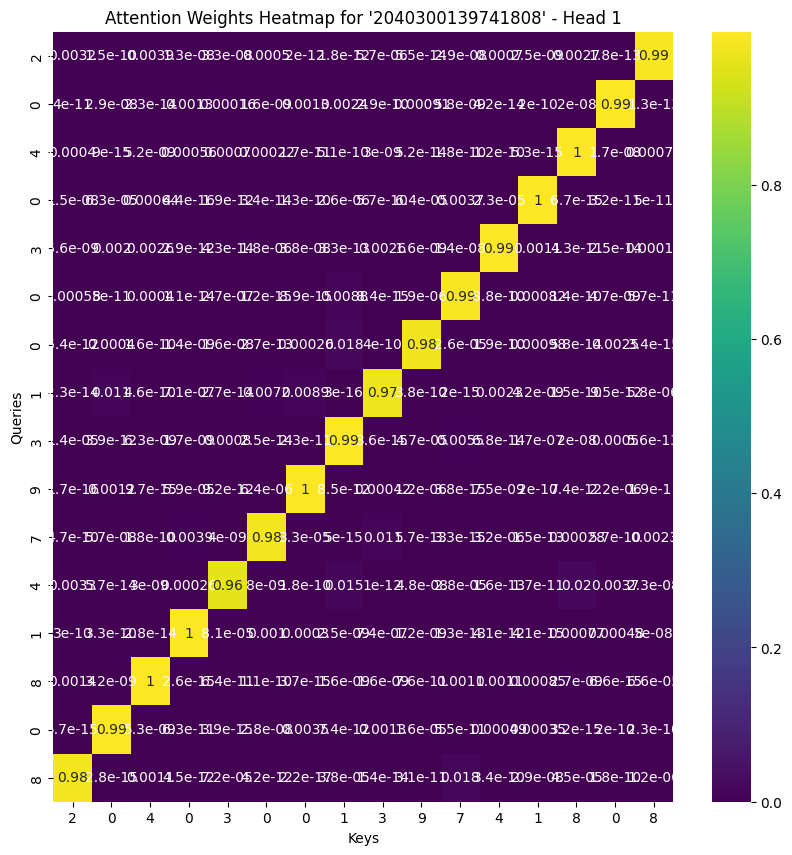

In [31]:
# Input data: tensor([2, 0, 4, 0, 3, 0, 0, 1, 3, 9, 7, 4, 1, 8, 0, 8])
# Labels:     tensor([8, 0, 8, 1, 4, 7, 9, 3, 1, 0, 0, 3, 0, 4, 0, 2])

input = "2040300139741808"
label = input[::-1]

for head in range(num_heads):
    plt.figure(figsize=(10, 10))

    attention_matrix = attention_weights[-1, head, :, :].detach().numpy()

    sns.heatmap(attention_matrix, annot=True, cmap='viridis', xticklabels=input, yticklabels=input)
    plt.title(f"Attention Weights Heatmap for '{input}' - Head {head+1}")
    plt.xlabel("Keys")
    plt.ylabel("Queries")
    plt.show()


The heatmap diagonal is correct because in the above image, we can
treat it as a $T \times T$  matrix, where the first row is the first token from query,
interacting with every other token as keys. So if first token is 2 and last token is 8,
then it should be matching each other because of the "reversal".